In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

In [84]:
import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"
import tempfile

from IPython.display import HTML, display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

import tdgl
from tdgl.geometry import box, circle

In [85]:
solve_og = False
solve_layout = False
make_graphs = True

# Definición del dispositivo a usar

In [3]:
length_units = "um"

coherence_length = 0.5
london_lambda = 2
d = 0.1
gamma = 1

layer = tdgl.Layer(london_lambda=london_lambda, coherence_length=coherence_length, thickness=d, gamma=gamma)

total_width = 15
total_length = 10
link_width = total_width / 3

x = total_width / 2
y = total_length / 2
points = [(-x, y), (-x + 4, y), (-x + 4, y - 1), (-x + 2, y - 3.5), (-x, y - 3.5), (-x, y)]
top_left_notch = (tdgl.Polygon(points=points))
bottom_left_notch = top_left_notch.scale(yfact=-1)

points = [(0,y), (x,y), (x, y - 3.5), (-1.0, y - 3.5), (-1.5, y - 3.0), (0, y - 1), (0,y)]
top_right_notch = (tdgl.Polygon(points=points))
bottom_right_notch = top_right_notch.scale(yfact=-1)

film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .difference(top_left_notch, bottom_left_notch, top_right_notch, bottom_right_notch)
    .resample(401)
    .buffer(0)
)

radius = 2.2
hole = (
    tdgl.Polygon("hole", points=circle(radius=radius, center=(-3.3, 0)))
)

source = (
    tdgl.Polygon("source", points=box(0.2, 2))
    .translate(dx = -total_width / 2)
)

drain = source.scale(xfact=-1).set_name("drain")
#
probe_points = [(-6.5,0),(6.5,0)]


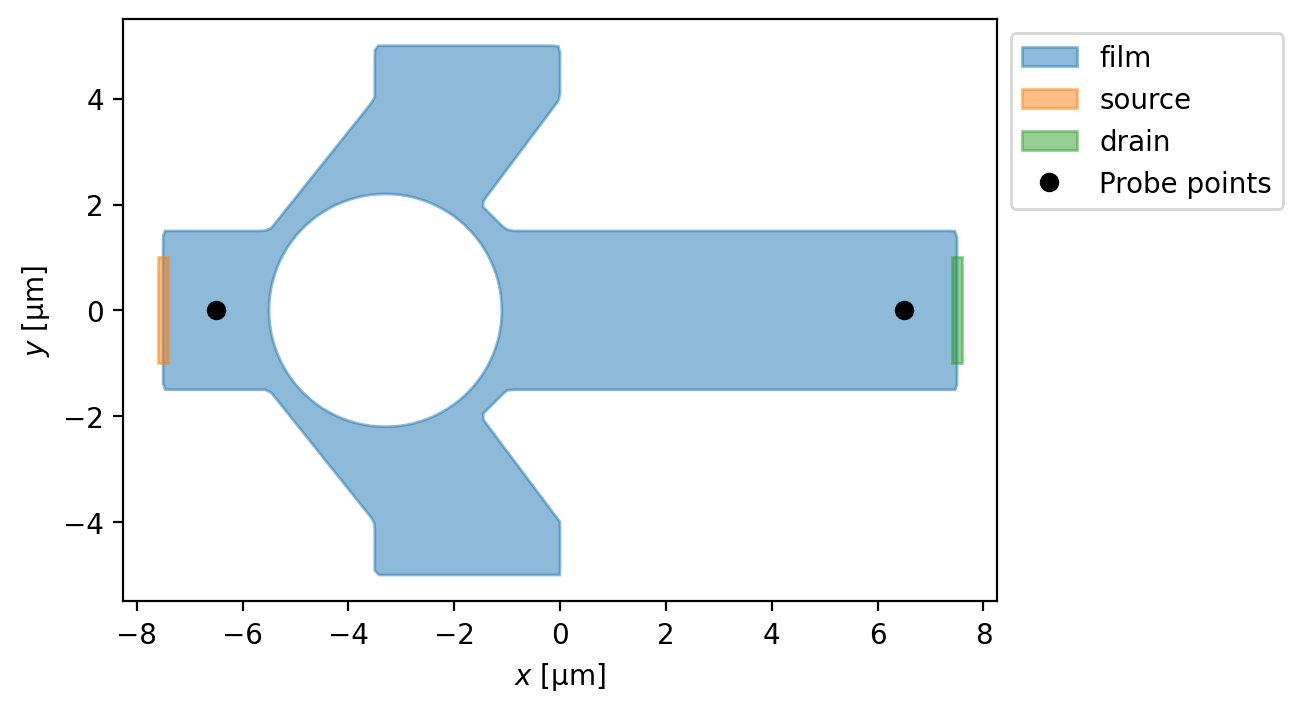

In [4]:
og_device = tdgl.Device(
    "original_device",
    layer=layer,
    film=film,
    holes=[hole],
    length_units=length_units,
    terminals=[source, drain],
    probe_points=probe_points,
)

fix, ax = og_device.draw()

Constructing Voronoi polygons: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3127/3127 [00:00<00:00, 31409.84it/s]


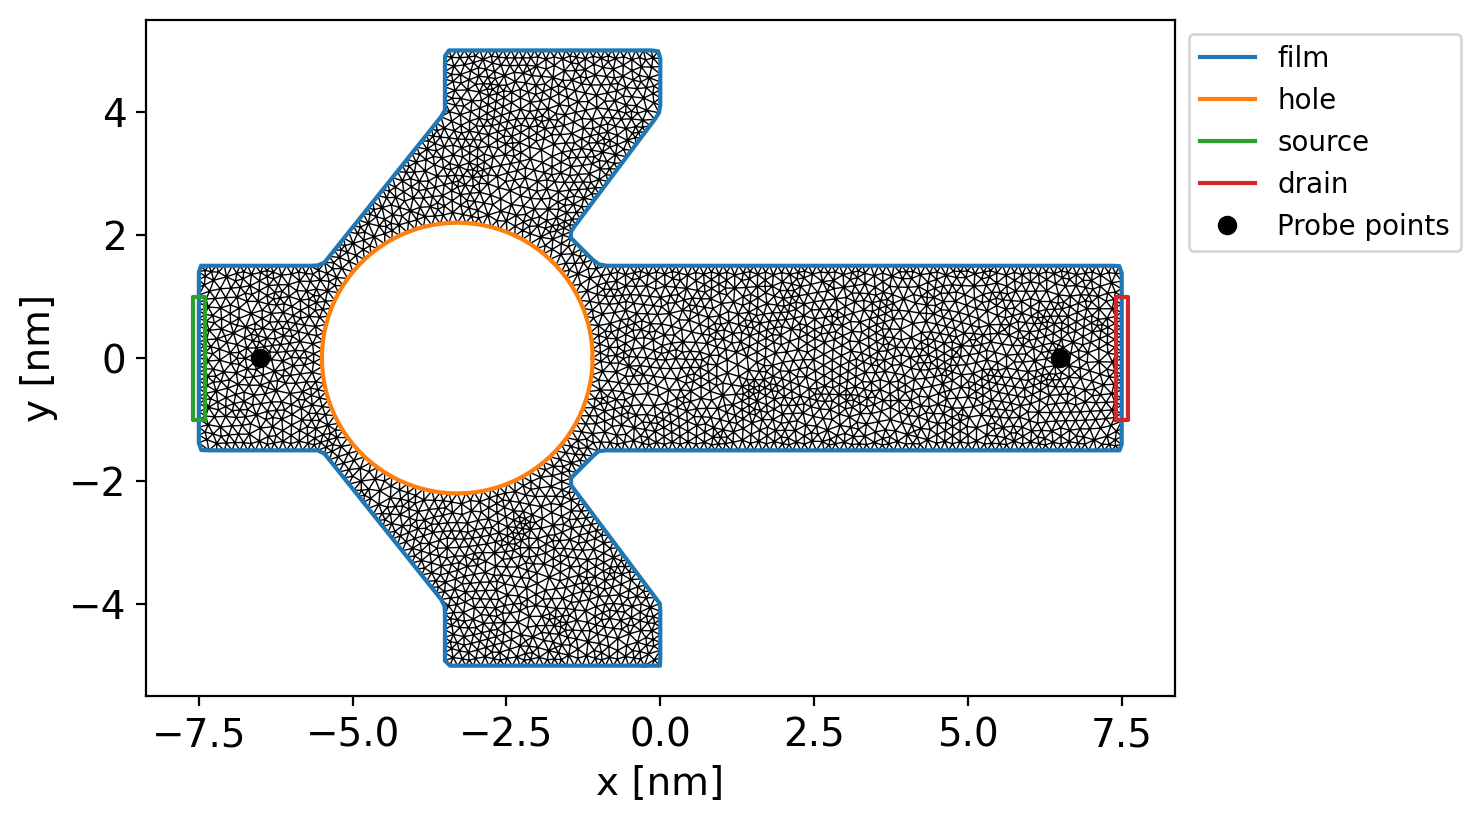

In [5]:
og_device.make_mesh(max_edge_length= coherence_length/2, smooth=100)

fig, ax = og_device.plot(mesh=True, legend=True, figsize=(9,4))

ax.set_xlabel("x [nm]",fontsize="14")
ax.set_ylabel("y [nm]",fontsize="14")
ax.tick_params(axis="both", labelsize=14)

# Gráfica de corrientes en el conductor

In [6]:
default_terminal_currents = {
    'source': 12,
    'drain' : -12
}

with tempfile.TemporaryDirectory(dir=os.getcwd()) as tmpdir:
    options = tdgl.SolverOptions(
        skip_time=100,
        solve_time = 200,
        output_file = os.path.join(tmpdir, "current_field.h5"),
        field_units= "mT",
        current_units= "uA",
        save_every=100,
    )

    solution_without_field = tdgl.solve(device=og_device, options=options, terminal_currents=default_terminal_currents)

Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 200/200 [00:15<00:00, 12.94tau/s ]


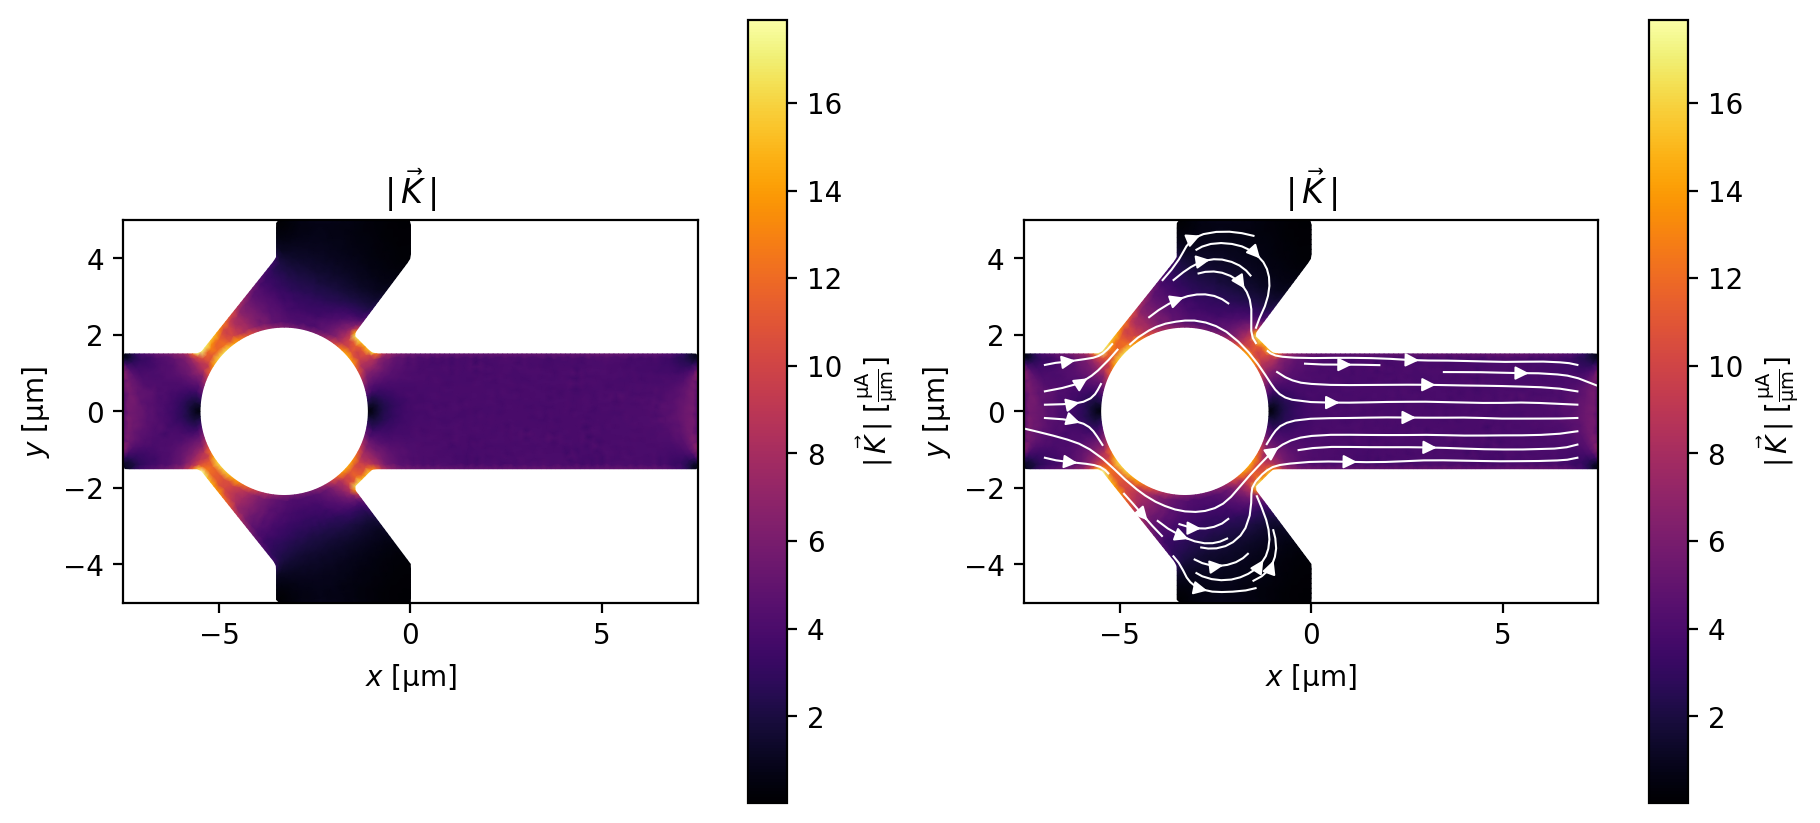

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(9,4), constrained_layout=True)

_ = solution_without_field.plot_currents(ax=axes[0], streamplot=False)
_ = solution_without_field.plot_currents(ax=axes[1])


# Graphic V vs I

In [8]:
def get_mean_voltage(device, options, current):
    terminal_currents = {
        'source': current,
        'drain': -current,
    }

    solution = tdgl.solve(device=device, options=options, terminal_currents=terminal_currents)
    return solution.dynamics.mean_voltage()

In [87]:
if solve_og:
    for current in currents:
        with tempfile.TemporaryDirectory(dir=os.getcwd()) as tmpdir:
            options = tdgl.SolverOptions(
                skip_time=100,
                solve_time = 200,
                output_file = os.path.join(tmpdir, "current_field.h5"),
                field_units= "mT",
                current_units= "uA",
                save_every=100,
            )
    
            currents = np.arange(0.0, 10.0, 0.02)
    
            voltage_current_save_file = "V_vs_I_conductor_"
            raw_data_path = os.path.join("raw_data", voltage_current_save_file + og_device.name + ".csv")
    
            if os.path.exists(raw_data_path):
                os.remove(raw_data_path)
            
            df = pd.DataFrame({'current_uA': [current], 'voltage_V': [get_mean_voltage(og_device, options, current)]})
            df.to_csv(raw_data_path, mode='a', header=not os.path.exists(raw_data_path), index=False)

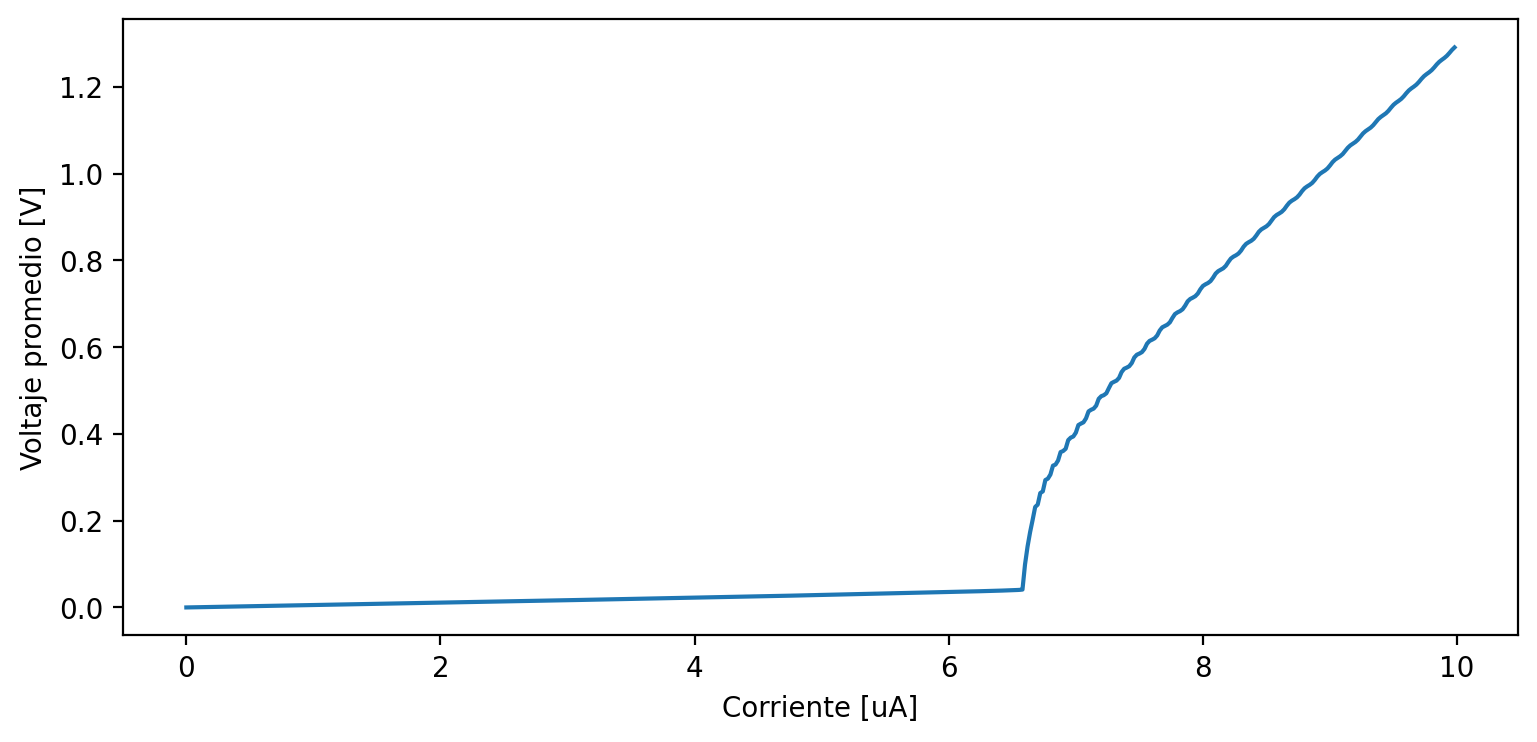

In [89]:
if make_graphs:
    og_device_raw_data = pd.read_csv(os.path.join("raw_data", voltage_current_save_file + og_device.name + ".csv")).to_numpy()
    
    plt.figure(figsize=(9,4))
    plt.plot([d[0] for d in og_device_raw_data], [d[1] for d in og_device_raw_data], linestyle='-')
    plt.xlabel('Corriente [uA]')
    plt.ylabel('Voltaje promedio [V]')
    plt.show()

# Current in multiple Source - Drain configurations

In [15]:
devices = []

left_source = source = (
    tdgl.Polygon("source", points=box(0.2, 2))
    .translate(dx = -total_width / 2)
)

right_drain = left_source.scale(xfact=-1).set_name('drain')

top_source = (
    tdgl.Polygon("source", points=box(2, 0.2))
    .translate(dy = total_length / 2, dx = -1.8)
)

bot_drain = top_source.scale(yfact=-1).set_name('drain')

top_probe = (-1.8, 4)
bot_probe = (-1.8, -4)
left_probe = (-6.5, 0)
right_probe = (6.5, 0)

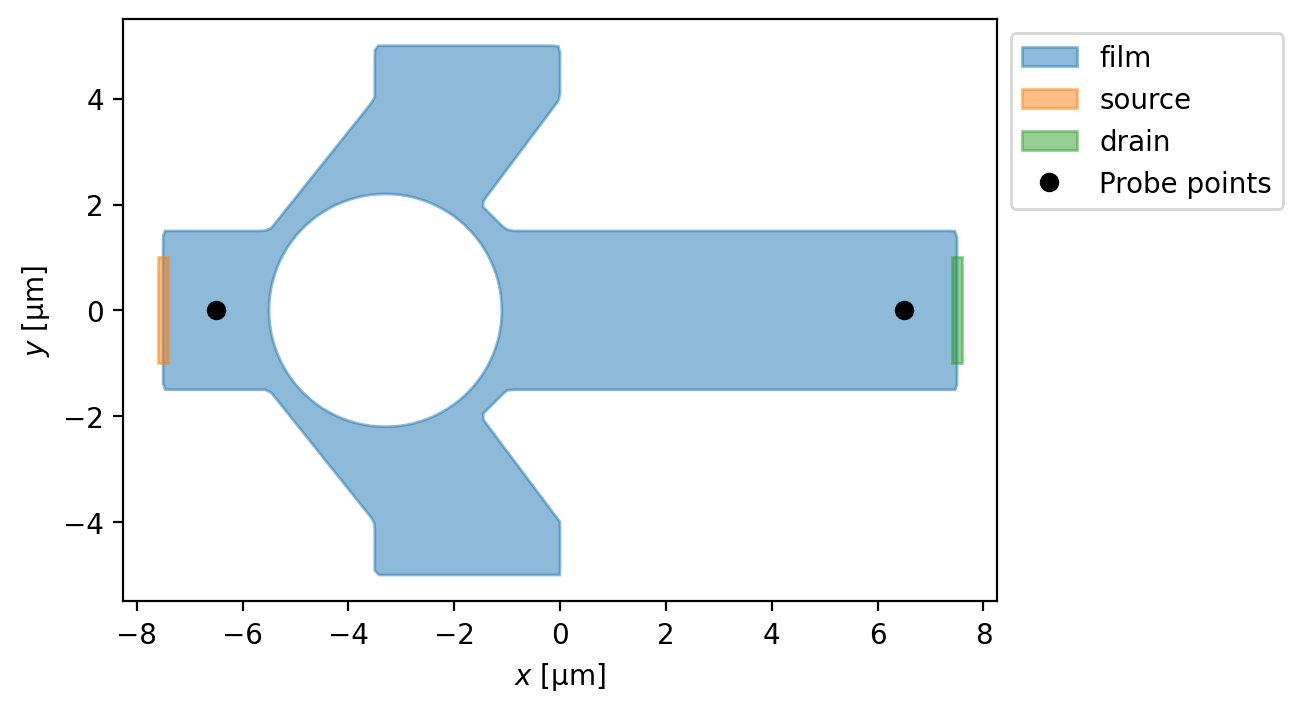

In [16]:
ltr_device = tdgl.Device(
    "ltr",
    layer=layer,
    film=film,
    holes=[hole],
    length_units=length_units,
    terminals=[left_source, right_drain],
    probe_points=[left_probe, right_probe],
)

devices.append(ltr_device) if ltr_device not in devices else None

fix, ax = ltr_device.draw()

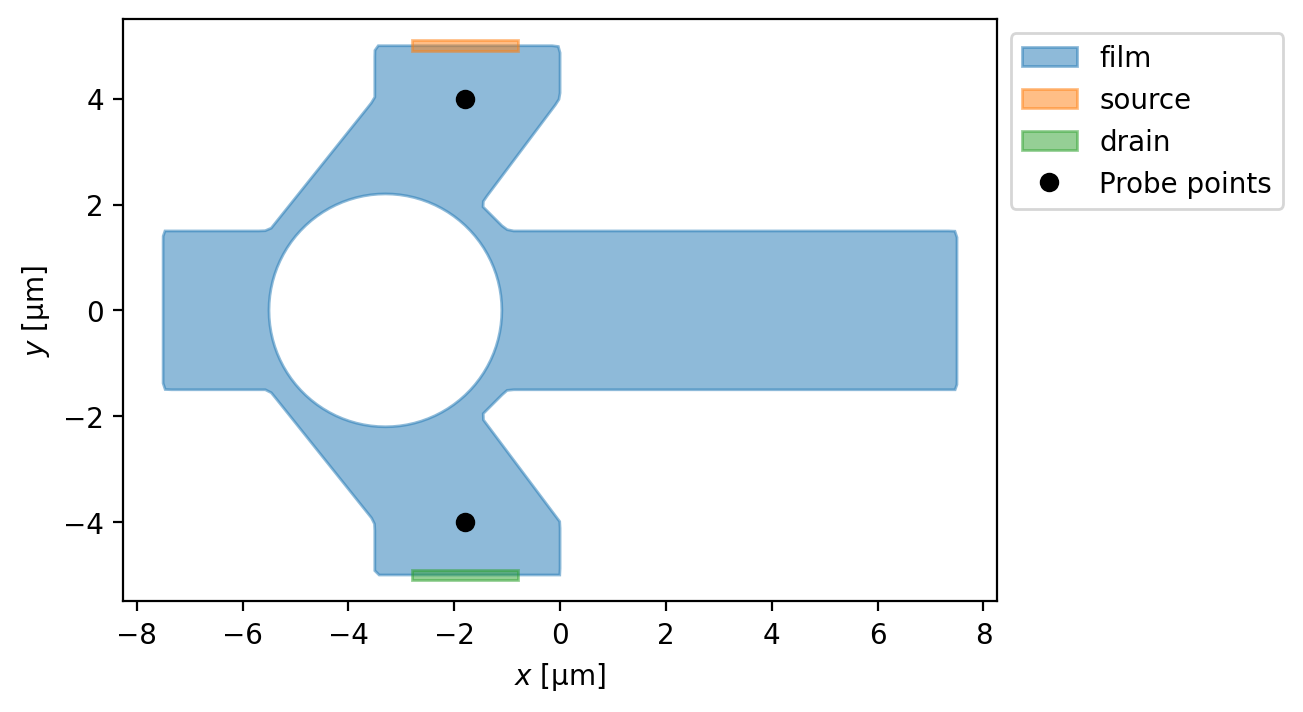

In [17]:
ttb_device = tdgl.Device(
    "ttb",
    layer=layer,
    film=film,
    holes=[hole],
    length_units=length_units,
    terminals=[top_source, bot_drain],
    probe_points=[top_probe, bot_probe],
)

devices.append(ttb_device) if ttb_device not in devices else None

fix, ax = ttb_device.draw()

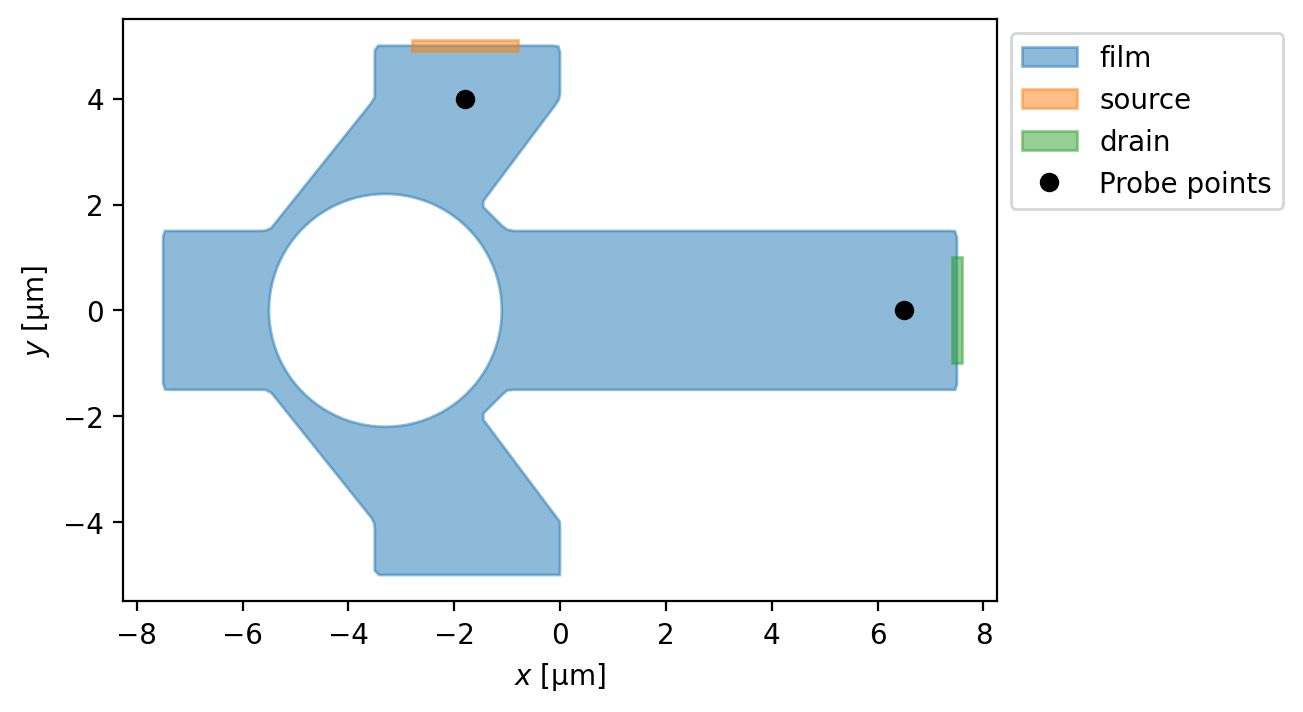

In [18]:
ttr_device = tdgl.Device(
    "ttr",
    layer=layer,
    film=film,
    holes=[hole],
    length_units=length_units,
    terminals=[top_source, right_drain],
    probe_points=[top_probe, right_probe],
)

devices.append(ttr_device) if ttr_device not in devices else None

fix, ax = ttr_device.draw()

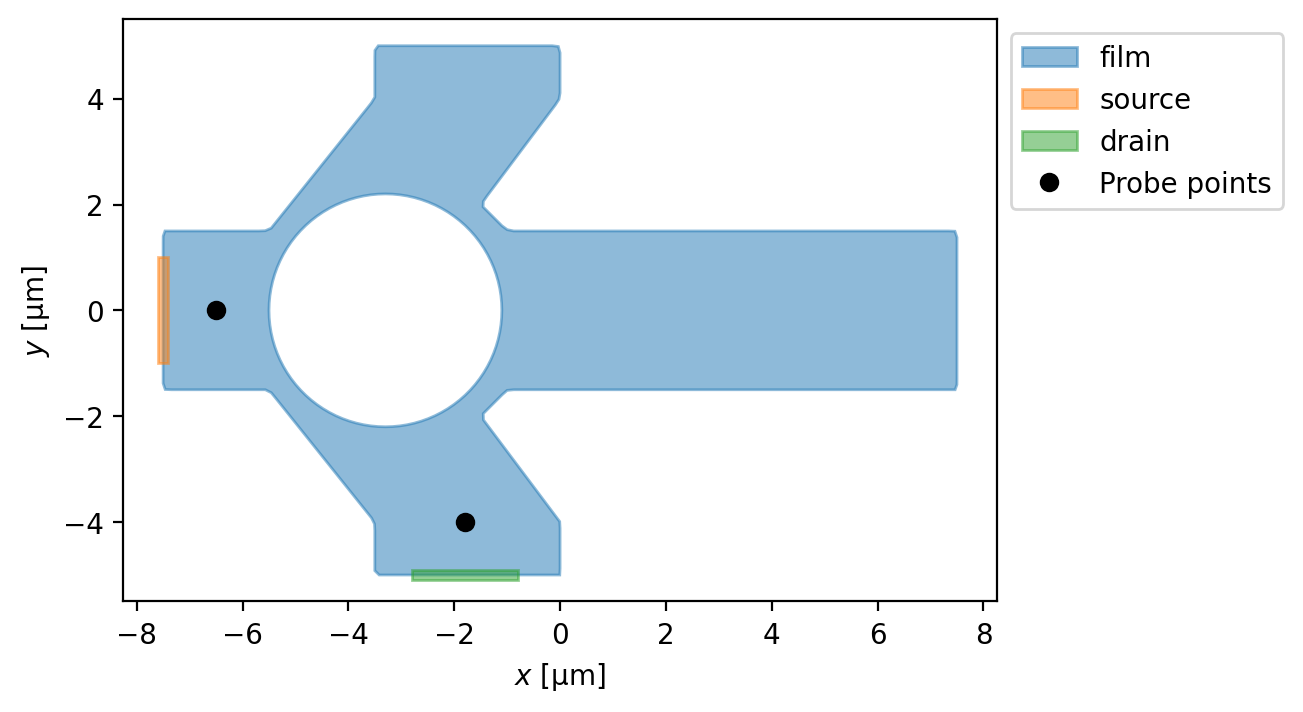

In [19]:
ltb_device = tdgl.Device(
    "ltb",
    layer=layer,
    film=film,
    holes=[hole],
    length_units=length_units,
    terminals=[left_source, bot_drain],
    probe_points=[left_probe, bot_probe],
)

devices.append(ltb_device) if ltb_device not in devices else None

fix, ax = ltb_device.draw()

Constructing Voronoi polygons: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3127/3127 [00:00<00:00, 31518.31it/s]


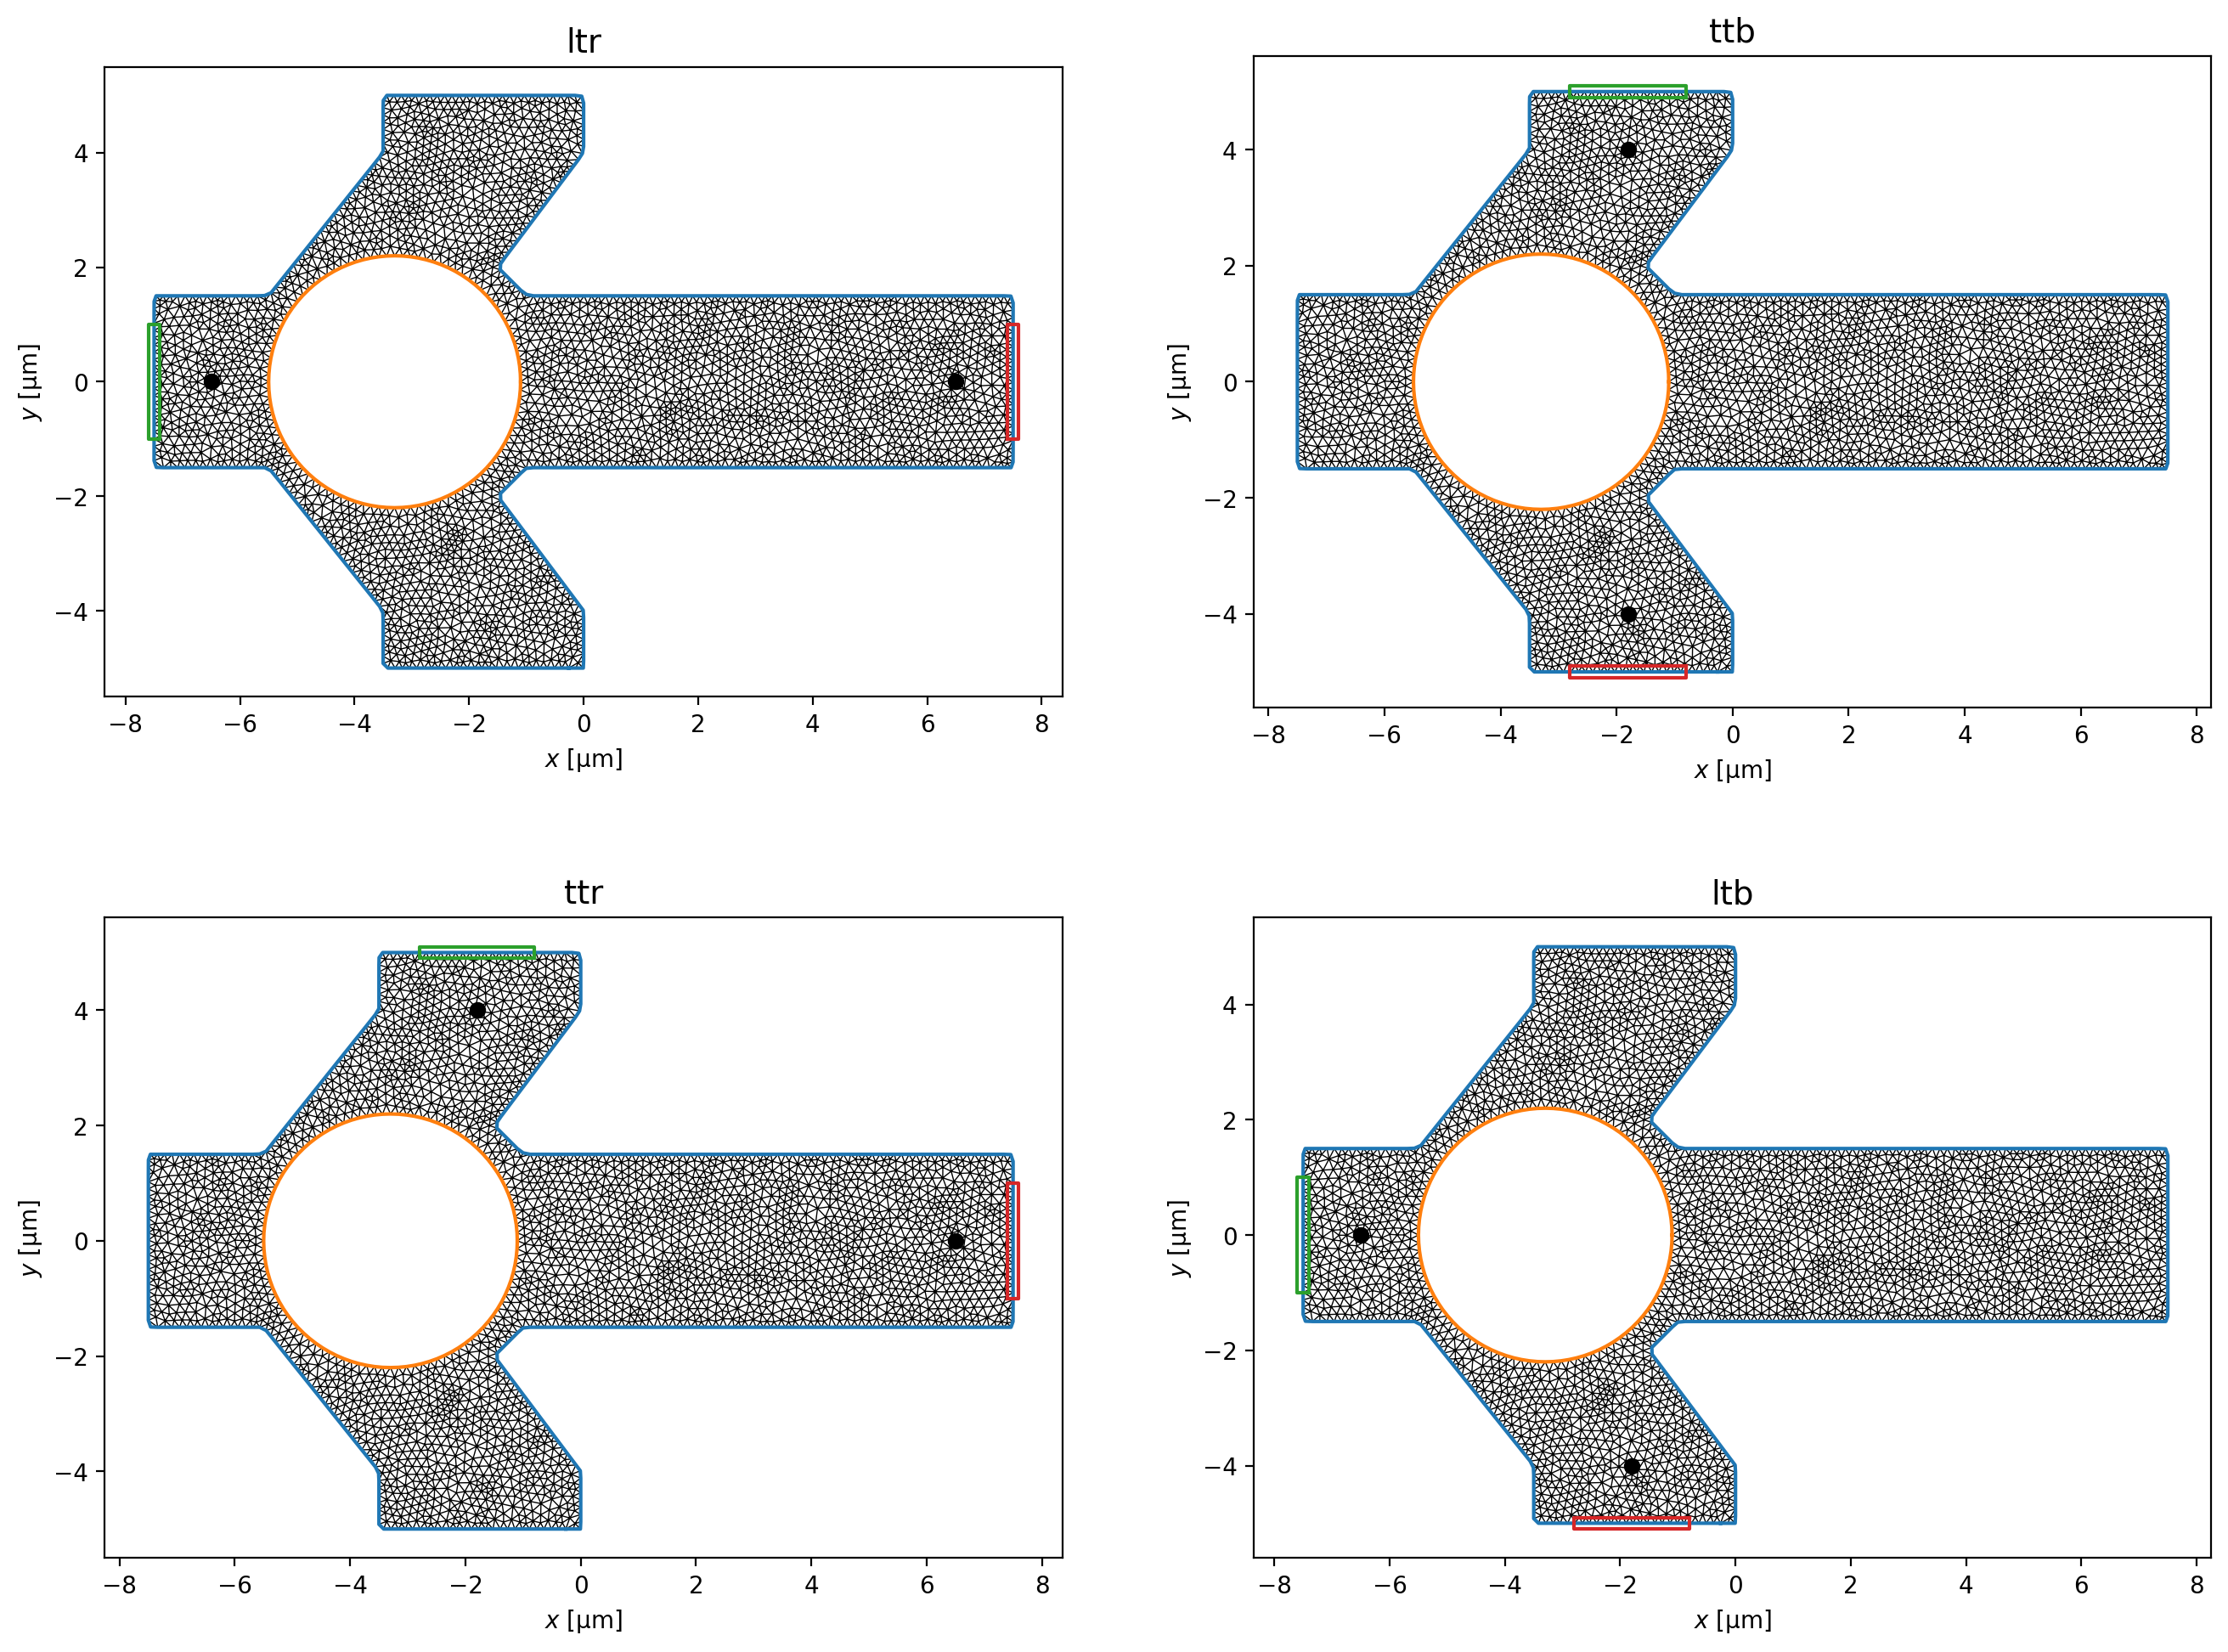

In [20]:
plt.figure(figsize=(16, 12))

if len(devices) == 4:
    for i, d in enumerate(devices):
        d.make_mesh(max_edge_length=coherence_length/2, smooth=100)
        
        ax = plt.subplot(2, 2, i + 1)
        fig, _ = d.plot(mesh=True, legend=False, ax=ax)
    
        ax.set_title(f"{d.name}", fontsize=14)

Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 200/200 [00:18<00:00, 10.63tau/s ]


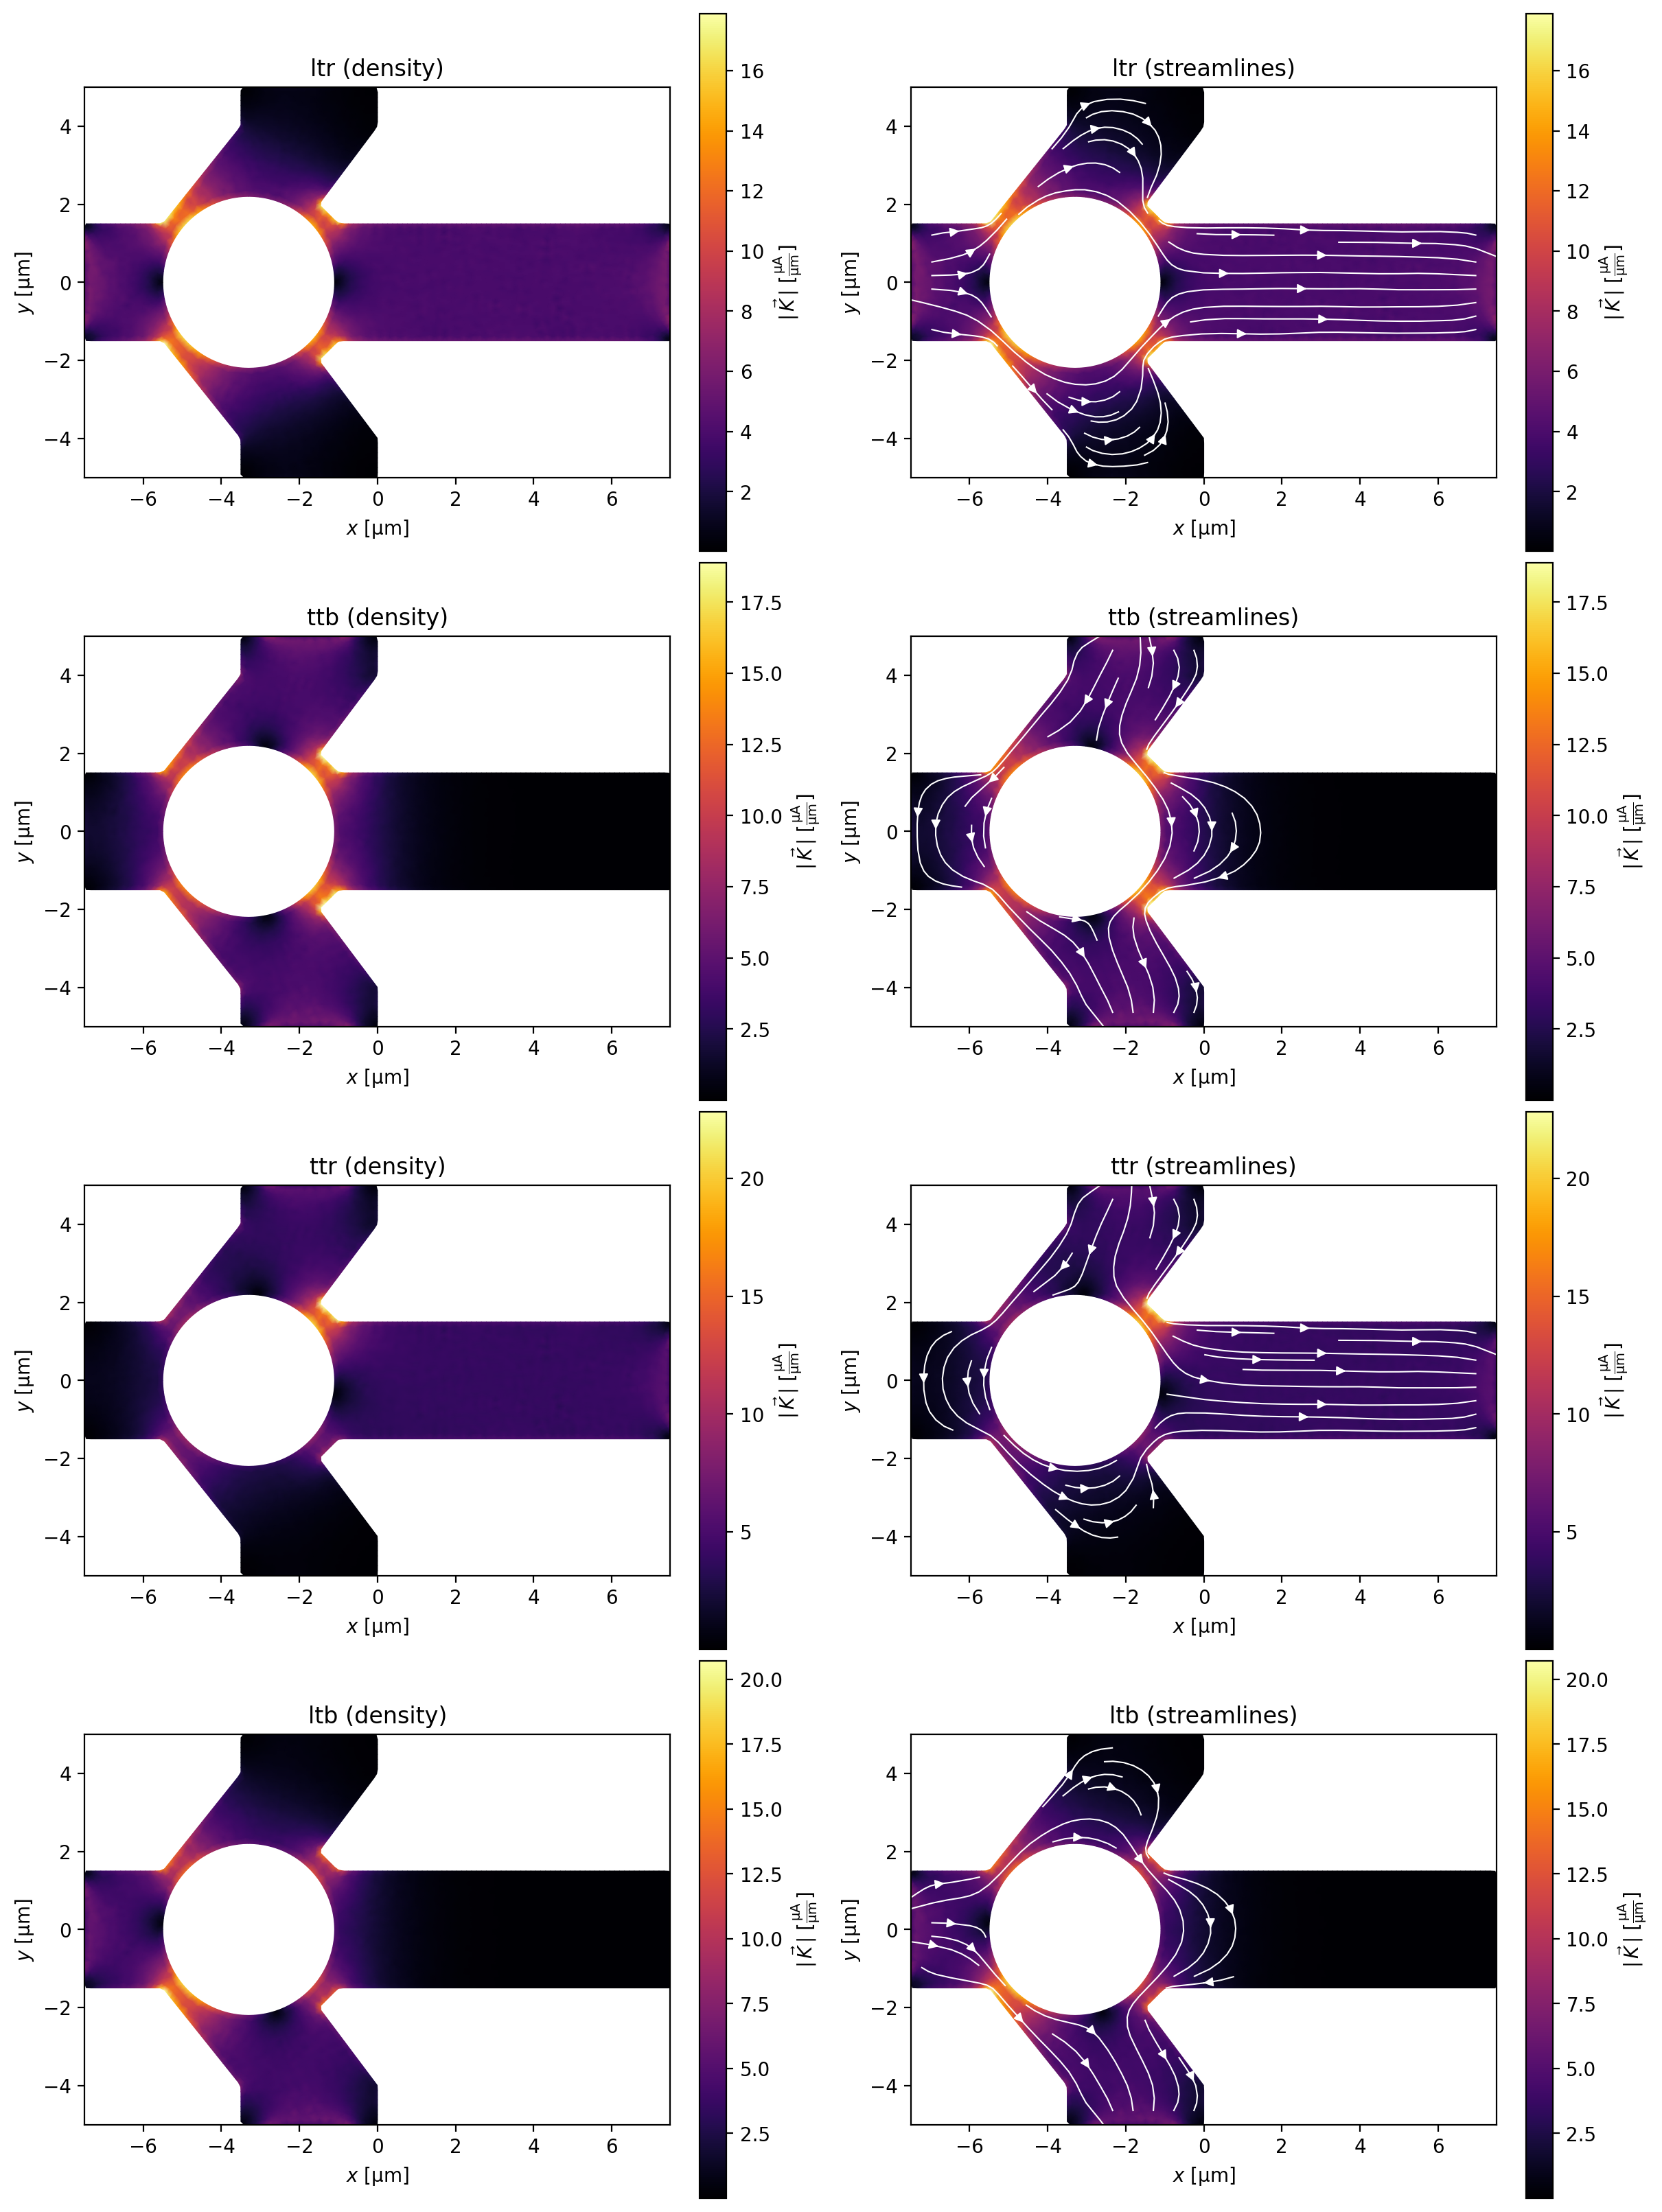

In [21]:
default_terminal_currents = {
    'source': 12,
    'drain': -12
}


fig, axes = plt.subplots(len(devices), 2, figsize=(12, 4*len(devices)), constrained_layout=True)

for i, d in enumerate(devices):
    with tempfile.TemporaryDirectory(dir=os.getcwd()) as tmpdir:
        options = tdgl.SolverOptions(
            solve_time = 200,
            output_file = os.path.join(tmpdir, "current_field.h5"),
            field_units= "mT",
            current_units= "uA",
        )
        solve = tdgl.solve(device=d, options=options, terminal_currents=default_terminal_currents)

        solve.plot_currents(ax=axes[i, 0], streamplot=False)
        axes[i, 0].set_title(f"{d.name} (density)", fontsize=12)

        solve.plot_currents(ax=axes[i, 1], streamplot=True)
        axes[i, 1].set_title(f"{d.name} (streamlines)", fontsize=12)

# Gráfica V vs I para cada layout

In [22]:
csv_prefix = "V_vs_I_layout_"

def get_v_vs_i_for_device(d, current):
    with tempfile.TemporaryDirectory(dir=os.getcwd()) as tmpdir:
        options = tdgl.SolverOptions(
            skip_time= 100,
            solve_time = 200,
            output_file = os.path.join(tmpdir, "current_field.h5"),
            field_units= "mT",
            current_units= "uA",
        )

        raw_data_path = os.path.join("raw_data", csv_prefix + d.name + ".csv")
        if os.path.exists(raw_data_path):
            os.remove(raw_data_path)

        for current in currents:
            df = pd.DataFrame({'current_uA': [current], 'voltage_V': [get_mean_voltage(d, options, current)]})
            df.to_csv(raw_data_path, mode='a', header=not os.path.exists(raw_data_path), index=False)

In [28]:
currents = np.arange(3.5, 9.0, 0.01)

In [ ]:
if solve_layout:
    for device in devices:
        get_v_vs_i_for_device(device, current=currents)

In [49]:
ltr_raw_data = pd.read_csv(os.path.join("raw_data", csv_prefix + ltr_device.name + ".csv")).to_numpy()
ttb_raw_data = pd.read_csv(os.path.join("raw_data", csv_prefix + ttb_device.name + ".csv")).to_numpy()
ltb_raw_data = pd.read_csv(os.path.join("raw_data", csv_prefix + ltb_device.name + ".csv")).to_numpy()
ttr_raw_data = pd.read_csv(os.path.join("raw_data", csv_prefix + ttr_device.name + ".csv")).to_numpy()

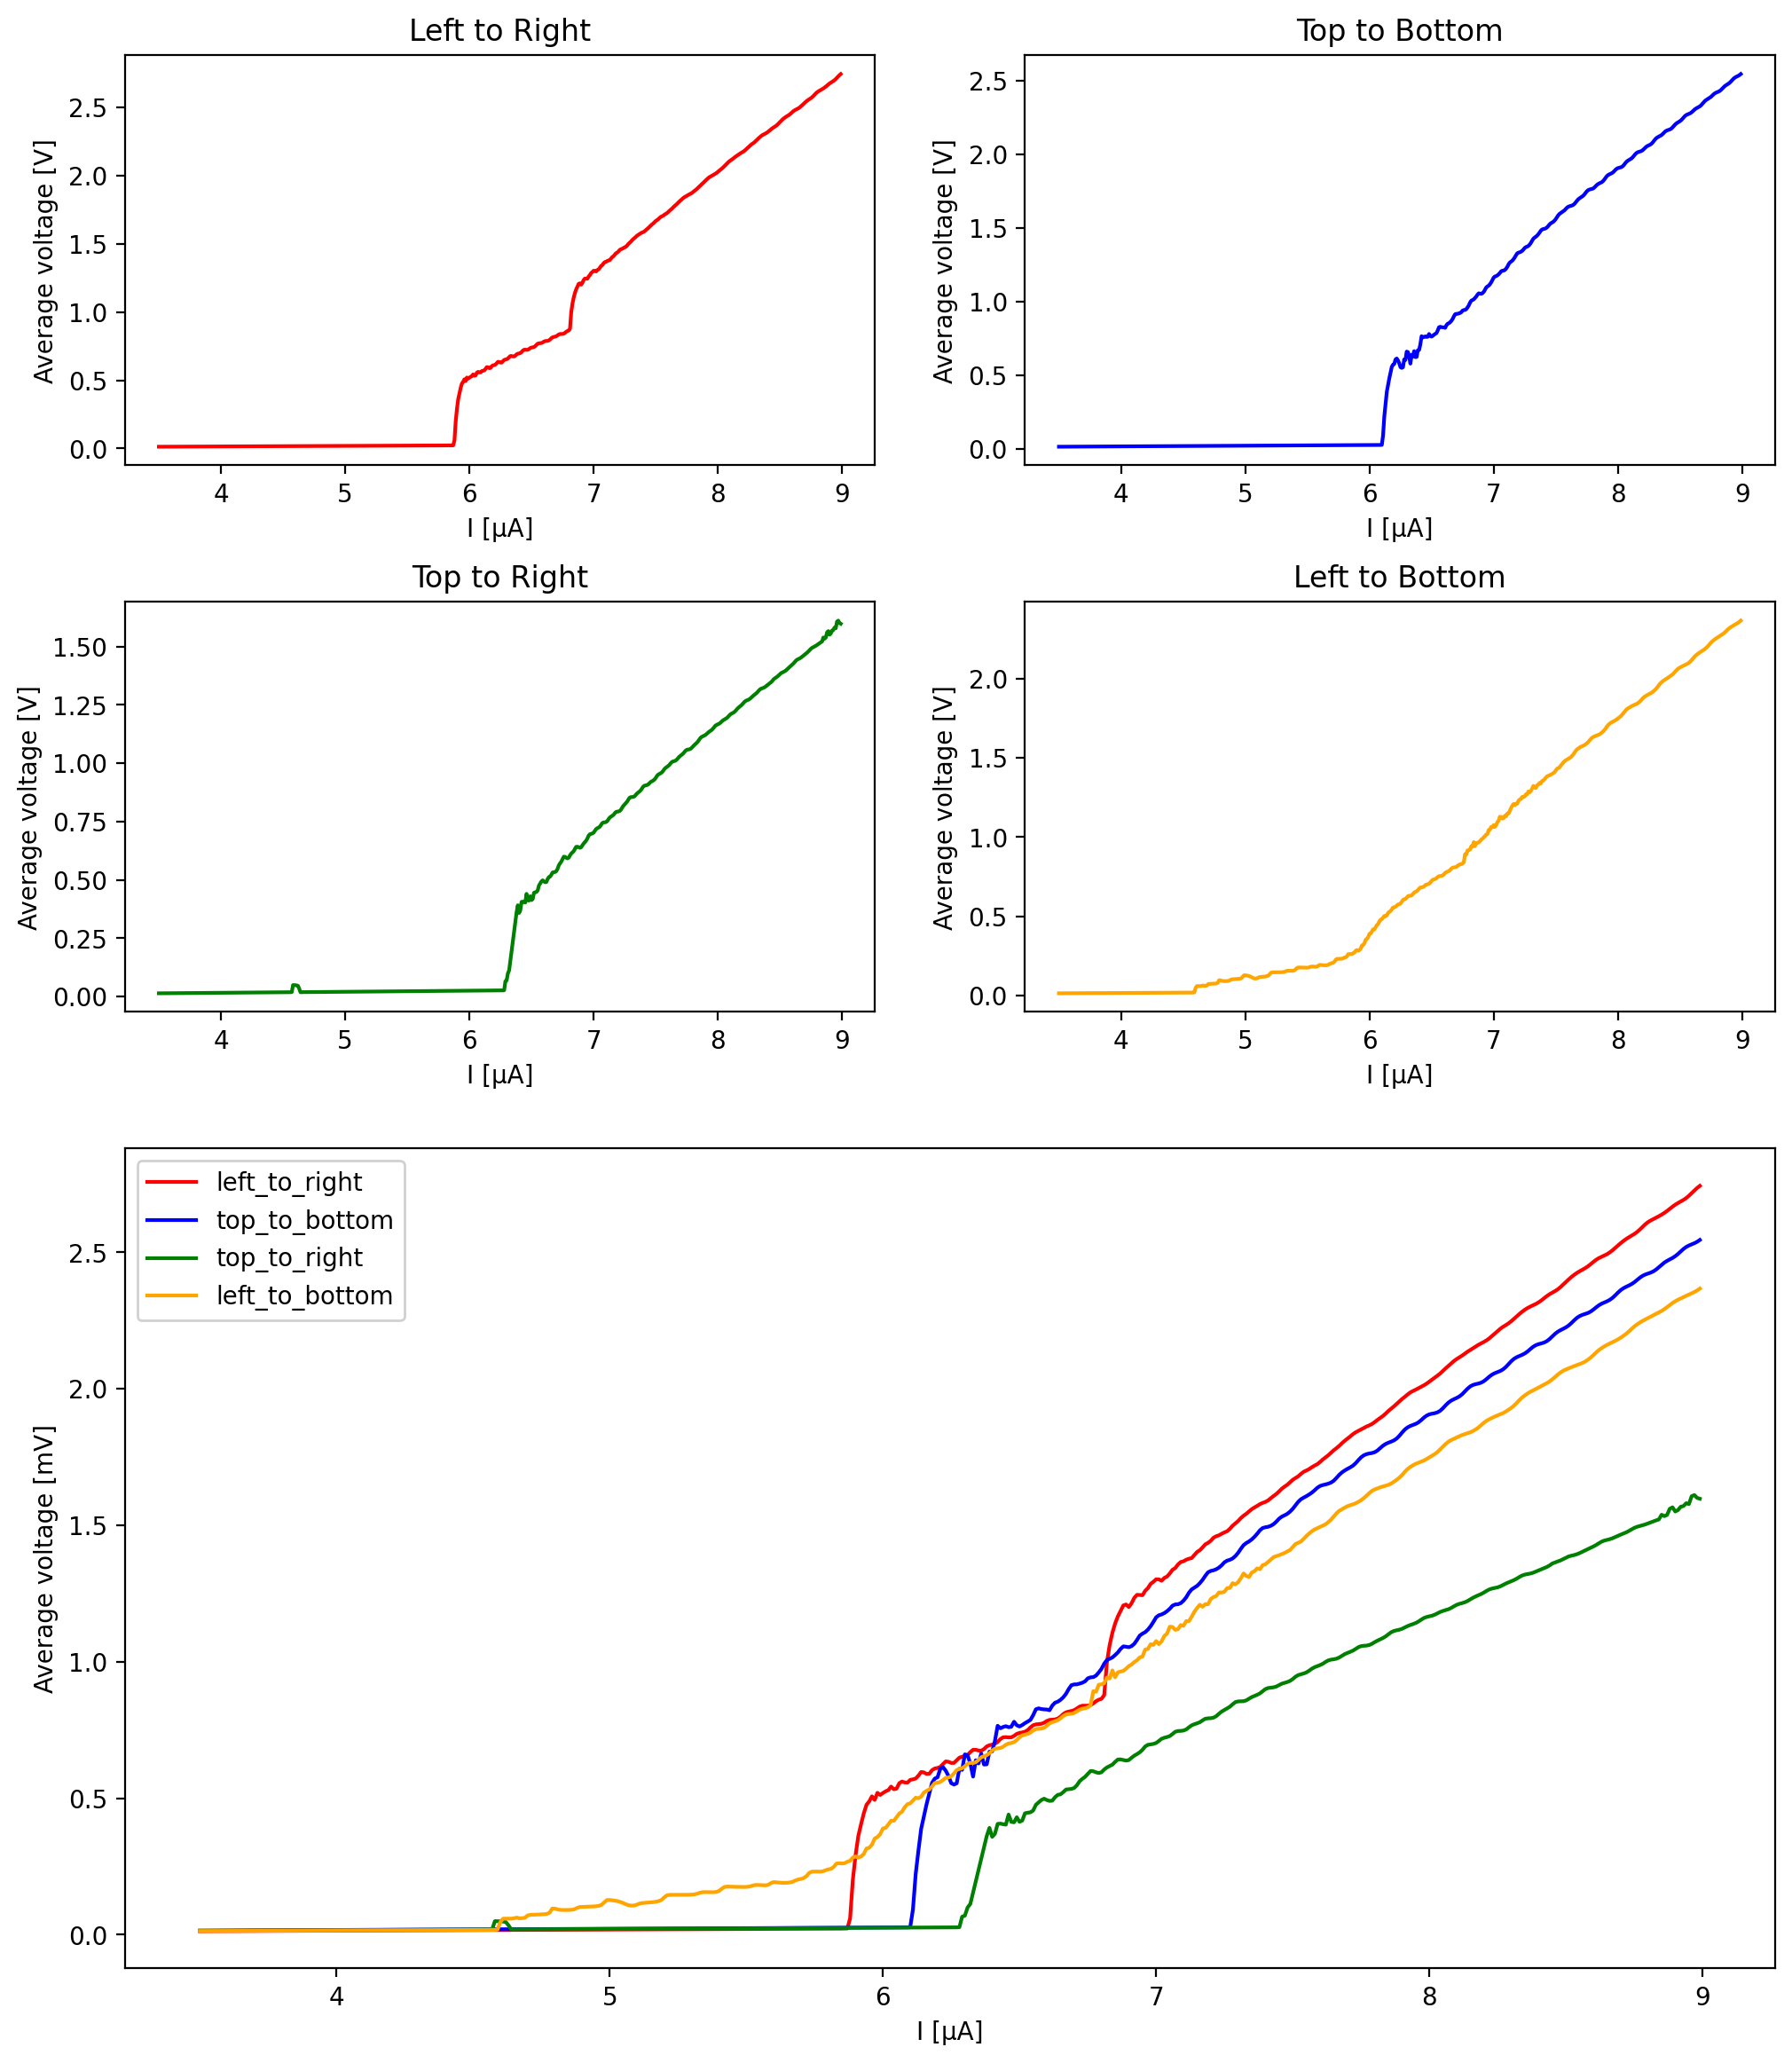

In [83]:
fig = plt.figure(figsize=(12,14))

colors = {
    "ltr": "red",
    "ttb": "blue",
    "ttr": "green",
    "ltb": "orange"
}

plot_configs = {
    "linestyle": "-",
    "linewidth": 1.5
}

gs = fig.add_gridspec(3, 2, height_ratios=[1,1,2], hspace=0.25)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot([i[0] for i in ltr_raw_data], [v[1] for v in ltr_raw_data], label="left_to_right", color=colors["ltr"], **plot_configs)
ax1.set_title("Left to Right")
ax1.set_xlabel("I [µA]")
ax1.set_ylabel("Average voltage [V]")

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot([i[0] for i in ttb_raw_data], [v[1] for v in ttb_raw_data], label="left_to_right", color=colors["ttb"], **plot_configs)
ax2.set_title("Top to Bottom")
ax2.set_xlabel("I [µA]")
ax2.set_ylabel("Average voltage [V]")

ax3 = fig.add_subplot(gs[1, 0])
ax3.plot([i[0] for i in ttr_raw_data], [v[1] for v in ttr_raw_data], label="top-to-right", color=colors["ttr"], **plot_configs)
ax3.set_title("Top to Right")
ax3.set_xlabel("I [µA]")
ax3.set_ylabel("Average voltage [V]")

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot([i[0] for i in ltb_raw_data], [v[1] for v in ltb_raw_data], label="left-to-bottom", color=colors["ltb"], **plot_configs)
ax4.set_title("Left to Bottom")
ax4.set_xlabel("I [µA]")
ax4.set_ylabel("Average voltage [V]")

ax_big = fig.add_subplot(gs[2, :])
ax_big.plot([i[0] for i in ltr_raw_data], [v[1] for v in ltr_raw_data], label="left_to_right", color=colors["ltr"], **plot_configs)
ax_big.plot([i[0] for i in ttb_raw_data], [v[1] for v in ttb_raw_data], label="top_to_bottom", color=colors["ttb"], **plot_configs)
ax_big.plot([i[0] for i in ttr_raw_data], [v[1] for v in ttr_raw_data], label="top_to_right", color=colors["ttr"], **plot_configs)
ax_big.plot([i[0] for i in ltb_raw_data], [v[1] for v in ltb_raw_data], label="left_to_bottom", color=colors["ltb"], **plot_configs)
ax_big.set_xlabel("I [µA]")
ax_big.set_ylabel("Average voltage [mV]")
ax_big.legend(loc="upper left", framealpha=0.9)

plt.show()

# Gráfica V vs I variando el campo